In [1]:
import pandas as pd
import numpy as np
from metrics import *
from matplotlib import pyplot as plt

EMBEDDINGS = {}

In [2]:
class CustomDataset:
    def __init__(self, data, target):
        self.data = data
        self.target = target

In [3]:
def get_dataset(name):
    if name == 'credit_card':
        all_data = pd.read_csv('../../data/density_based_clustering_data.csv')
        data = CustomDataset(
            all_data.loc[:, all_data.columns != 'class'].to_numpy(),
            all_data.loc[:, all_data.columns == 'class'].to_numpy().flatten()
        )
        return data
    if name == 'digits':
        from sklearn.datasets import load_digits
        data = load_digits()
        return data
    if name == 'iris':
        from sklearn.datasets import load_iris
        data = load_iris()
        return data

def get_tsne(X):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(learning_rate='auto', init='random').fit_transform(X)
    return X_embedded

def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    from matplotlib.cm import get_cmap
    import seaborn as sbn
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sbn.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                fit_reg=False,
                **kwargs
            )
        )
    
    return regplots

def get_plot(X, Y, cluster_labels, title):
    data_embedded_combined_Y = pd.DataFrame(data=np.c_[X, Y], columns=['x', 'y'] + ['target'])
    data_embedded_combined_clustered = pd.DataFrame(data=np.c_[X, cluster_labels], columns=['x', 'y'] + ['target'])

    import seaborn as sbn
    # sbn.lmplot(data=data_embedded_combined, fit_reg=False, x='x', y='y', hue='target')

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax1.set_title(title)
    hue_regplot(data=data_embedded_combined_Y, x='x', y='y', hue='target', ax=ax1)
    hue_regplot(data=data_embedded_combined_clustered, x='x', y='y', hue='target', ax=ax2)

    plt.show()
    plt.close()

def perform_clustering(X, n_clusters, linkage, dendrogram):
    from sklearn.cluster import AgglomerativeClustering

    if dendrogram:
        model = AgglomerativeClustering(n_clusters=None, distance_threshold=100000, linkage=linkage).fit(X)
    else:
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(X)
    return model.labels_, model

def extrinsic_scores(labels, clusters):
    return {
        'adjusted_rand_index': adjusted_rand_index(labels, clusters),
        'adjusted_mutual_information': adjusted_mutual_information(labels, clusters)
    }

def intrinsic_scores(X, clusters):
    return {
        'silhoutte_coefficient': silhoutte_coefficient(X, clusters),
        'calinski_harabasz_index': calinski_harabasz_index(X, clusters),
        'davies_bouldin_index': davies_bouldin_index(X, clusters)
    }

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    from scipy.cluster.hierarchy import dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    f, (ax) = plt.subplots(1, 1, figsize=(30, 10))
    dendrogram(linkage_matrix, ax=ax, **kwargs)
    plt.show()
    plt.close()

def run_agglomerative(dataset_name, n_clusters, linkage, dendrogram=False):
    dataset = get_dataset(dataset_name)
    X = dataset.data
    Y = dataset.target
    if dataset_name in EMBEDDINGS:
        X_embedded = EMBEDDINGS[dataset_name]
    else:
        X_embedded = get_tsne(X)
        EMBEDDINGS[dataset_name] = X_embedded
    if linkage == 'random':
        clusters = np.random.randint(low=0, high=n_clusters, size=(X.shape[0]))
    else:
        clusters, model = perform_clustering(X, n_clusters, linkage, dendrogram)
    if not dendrogram:
        get_plot(X_embedded, Y, clusters, linkage)
        print(extrinsic_scores(Y, clusters))
        print(intrinsic_scores(X, clusters))
    if linkage != 'random' and dendrogram:
        plot_dendrogram(model)


In [4]:
linkages = ['ward', 'complete', 'average', 'single', 'random']

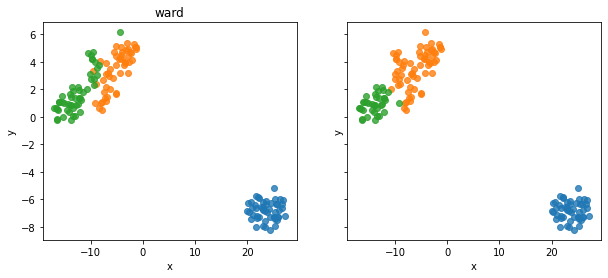

{'adjusted_rand_index': 0.7311985567707746, 'adjusted_mutual_information': 0.7671669615713113}
{'silhoutte_coefficient': 0.5543236611296419, 'calinski_harabasz_index': 558.0580408128307, 'davies_bouldin_index': 0.6562564540642021}


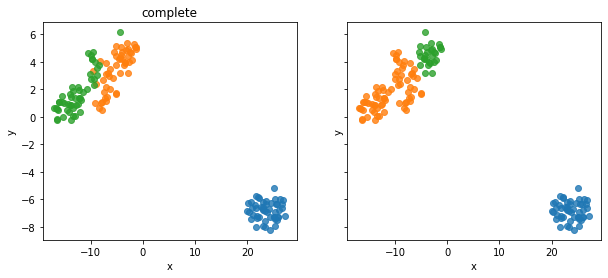

{'adjusted_rand_index': 0.6422512518362898, 'adjusted_mutual_information': 0.7184641371994783}
{'silhoutte_coefficient': 0.5135953221192214, 'calinski_harabasz_index': 485.9050227341817, 'davies_bouldin_index': 0.6333339304359707}


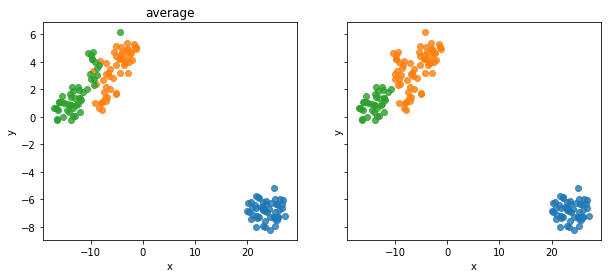

{'adjusted_rand_index': 0.7591987071071522, 'adjusted_mutual_information': 0.8032287370935434}
{'silhoutte_coefficient': 0.5541608580282851, 'calinski_harabasz_index': 556.8795419179529, 'davies_bouldin_index': 0.658444278322429}


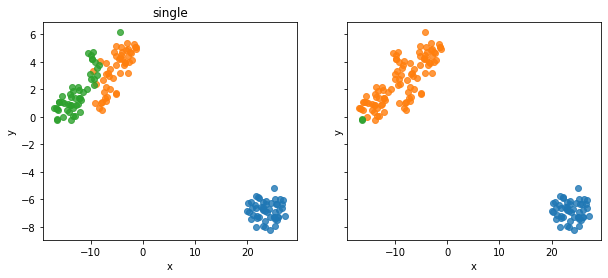

{'adjusted_rand_index': 0.5637510205230709, 'adjusted_mutual_information': 0.7125764811325078}
{'silhoutte_coefficient': 0.5121107753649307, 'calinski_harabasz_index': 277.9946762646194, 'davies_bouldin_index': 0.4471537628542408}


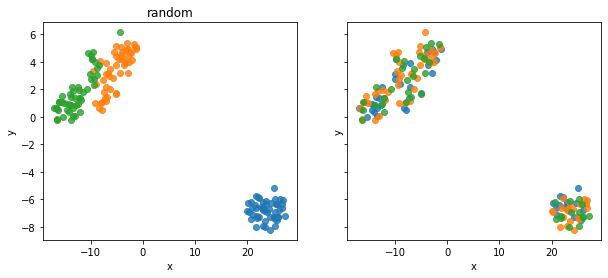

{'adjusted_rand_index': -0.008576546827028398, 'adjusted_mutual_information': -0.007805294331970338}
{'silhoutte_coefficient': -0.030499544458396647, 'calinski_harabasz_index': 0.4356346709590769, 'davies_bouldin_index': 31.32491975521464}


[None, None, None, None, None]

In [5]:
[run_agglomerative('iris', 3, linkage, False) for linkage in linkages]

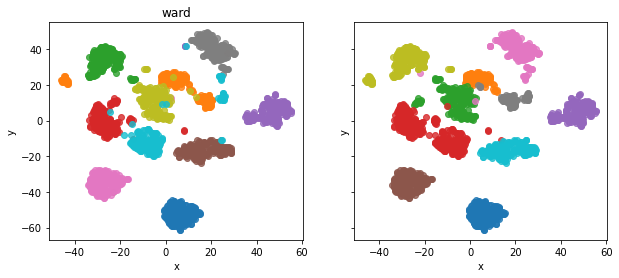

{'adjusted_rand_index': 0.7940031835568753, 'adjusted_mutual_information': 0.8668321489750319}
{'silhoutte_coefficient': 0.17849659940596496, 'calinski_harabasz_index': 161.20475281721804, 'davies_bouldin_index': 1.8889885974945109}


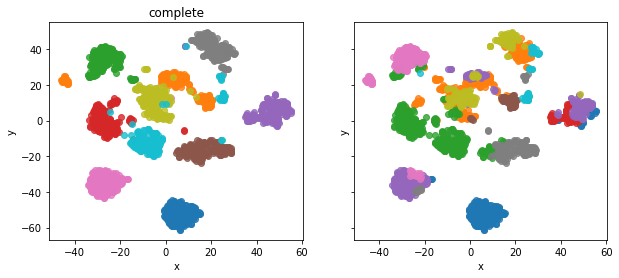

{'adjusted_rand_index': 0.4286888142937744, 'adjusted_mutual_information': 0.6091974206985212}
{'silhoutte_coefficient': 0.1192708999859292, 'calinski_harabasz_index': 117.41350520458832, 'davies_bouldin_index': 2.303120200595817}


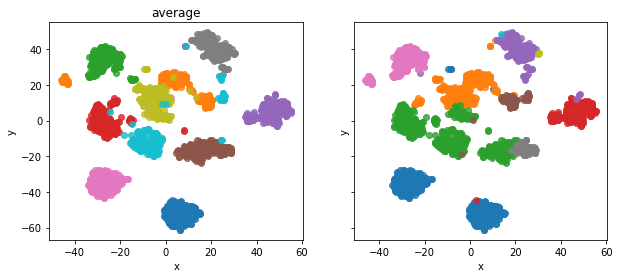

{'adjusted_rand_index': 0.5142255948681158, 'adjusted_mutual_information': 0.7103101155580299}
{'silhoutte_coefficient': 0.14662473962932557, 'calinski_harabasz_index': 122.1106003051252, 'davies_bouldin_index': 1.6868910302128672}


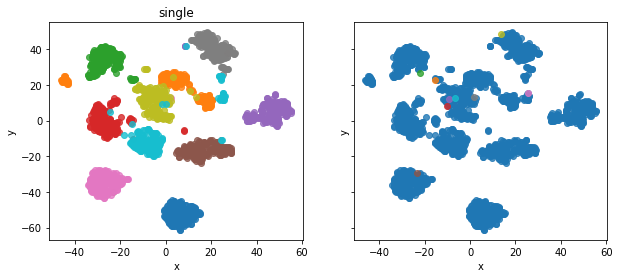

{'adjusted_rand_index': 4.313084144605482e-05, 'adjusted_mutual_information': 8.438956846943478e-05}
{'silhoutte_coefficient': -0.1336211433529001, 'calinski_harabasz_index': 1.2457366312330127, 'davies_bouldin_index': 0.9239238655143689}


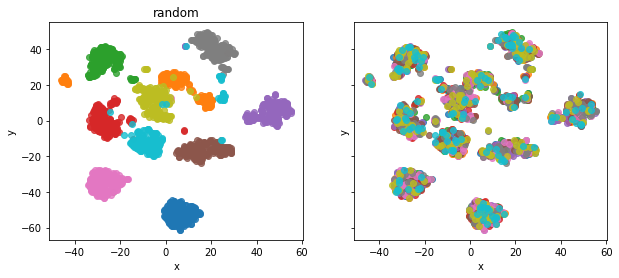

{'adjusted_rand_index': 9.050630833899276e-05, 'adjusted_mutual_information': 0.00014278208120282774}
{'silhoutte_coefficient': -0.019891258084087773, 'calinski_harabasz_index': 1.183059246541749, 'davies_bouldin_index': 22.984175540527808}


[None, None, None, None, None]

In [6]:
[run_agglomerative('digits', 10, linkage, False) for linkage in linkages]

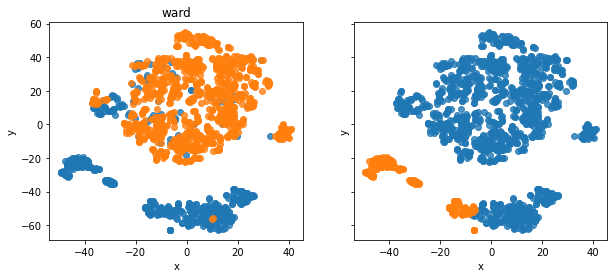

{'adjusted_rand_index': 0.27076842211221824, 'adjusted_mutual_information': 0.2854562141596948}
{'silhoutte_coefficient': 0.616058771099793, 'calinski_harabasz_index': 1465.1122546374725, 'davies_bouldin_index': 0.7303820743456186}


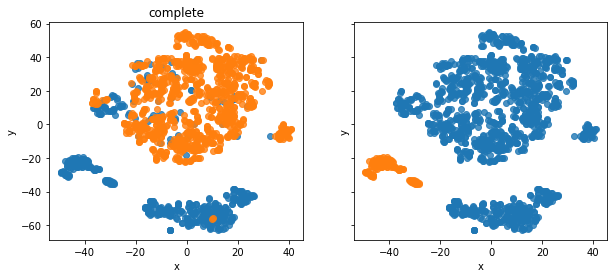

{'adjusted_rand_index': 0.16283326784844426, 'adjusted_mutual_information': 0.190766023260643}
{'silhoutte_coefficient': 0.6332235895986923, 'calinski_harabasz_index': 1115.3231428051263, 'davies_bouldin_index': 0.6402175854341382}


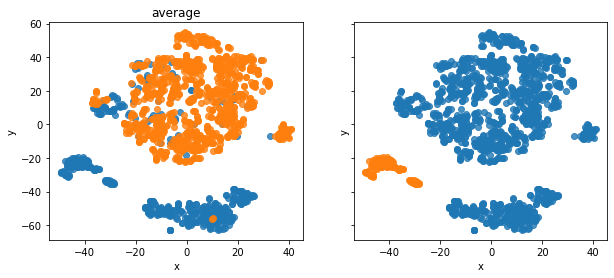

{'adjusted_rand_index': 0.16283326784844426, 'adjusted_mutual_information': 0.190766023260643}
{'silhoutte_coefficient': 0.6332235895986923, 'calinski_harabasz_index': 1115.3231428051263, 'davies_bouldin_index': 0.6402175854341382}


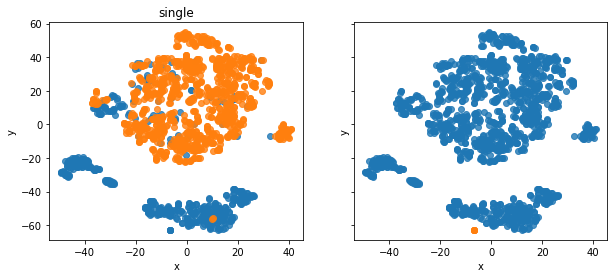

{'adjusted_rand_index': 0.008340962505214019, 'adjusted_mutual_information': 0.012404664954984173}
{'silhoutte_coefficient': 0.48271640000632, 'calinski_harabasz_index': 25.04426451658953, 'davies_bouldin_index': 0.4101553764083515}


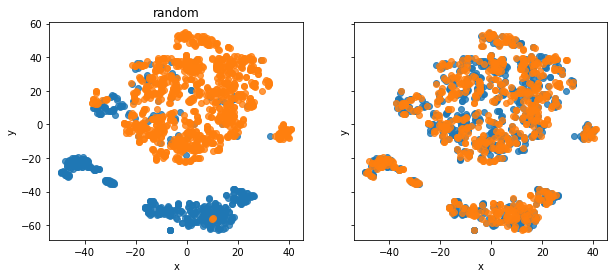

{'adjusted_rand_index': 0.0007160153634569259, 'adjusted_mutual_information': 0.0001391257340226606}
{'silhoutte_coefficient': -8.18347290053548e-05, 'calinski_harabasz_index': 0.3688799755325315, 'davies_bouldin_index': 53.329755744727095}


[None, None, None, None, None]

In [7]:
[run_agglomerative('credit_card', 2, linkage, False) for linkage in linkages]